# Multivariate time series: training and analysis

This notebook provides example code you can use for training and analysing your models. Note that **it is not advised** to run and train all models for this assignment in a single notebook. Ideally, in order not to loose your way in your own notebooks, you make **at least** a separate notebook for each type of model in this assignment, selecting only the code you need for that model.

You can get additional inspiration from the "Time series forecasting" demo notebook from the Tensorflow docs:

https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook heavily uses tensorflow utilities we haven't seen in class yet and is sometimes less easy to follow. We use some of the helper functions from that notebook in the code below.

## Imports and Drive mounting


In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE


2.4.1


## Assignment overview

The text below is de same as the text at the end of the preprocessing notebook. 

**However, one important piece of information was missing: we will use MAE (mean absolute error) to evaluate our models.**

In your last graded assignment, you will build a model to predict pollution in a big city on past pollution info as well as past wheather info. You receive a multi-variate time series data set which contains hourly data. 
**Your task is to predict pollution 3 hours ahead** in order to be able to build a citizen warning system. The error measure you need to minimise is Mean Absolute Error. As described in the preprocessing notebook, you will **use the pollution samples from the last year for testing** and **from the one-but-last year for validation**. 

We already provide the simplest time series prediction baseline: using the current pollution value as a prediction.

Your assignment consists of three steps (please also check the instructions in the slides):

1) First make the following baseline model: a network that only predicts pollution based on the **current values of all input time series (pollution and wheather)** to predict for 3 hours ahead, i.e. a purely feature based dense model that does not take history into account. You can also use this  model to do an initial investigation of the importance of each feature! 
This baseline should at least outperform the simplest baseline.

2) Then you make a second baseline that uses only **current pollution and pollution history**, so a single timeseries: a window-based dense network (the window size is an important hyperparameter to explore here).
This baseline should at least outperform the simplest baseline.

3) Now use all available information to build good time series models (using current values and histories of multiple features). Explore both, window-based and recurrent model types (cf. slides for additional instructions).  


## Analysis

Since this is a regression task, there are no misclassifications: the analysis should focus on visualising the predictions on train and validate or test sets. Code for this is suggested in the training notebook. Please make sure to not only make the necessary plots, but also to discuss them. Also provide an overview table of train, validate and test errors for teh models of each stage and a comparative discussion of model properties and performance.



## Timing

**This assignment is more extensive than the previous ones.** try to maximally use the experience you already gained to efficiently tune the networks. However, teh aim of this assignment is to explore and compare several approaches to time series prediction, not to try and get the very best scoring models. Once you find a network that is properly tuned, do not waste time on trying to get that extra small improvement. Try to focus on exploring and understanding which effect (if any) the different options have and link this back to theory about each model type and/or the properties of this data set. 

If you have time left after finishing all the tasks, you can still revisit your best model(s) to try and improve! However, be aware of the fact that this task will never be perfectly solvable, because you simply do not have enough information to perfectly predict pollution.

The deadline for this assignment is **Friday, March 19, 23:30**. 
This means you have 2 weeks: for a good planning, aim at finishing at least parts 1 and 2 in the first week! That way, you can use the hands-on support session to ask us whether you are on the right track.




In [3]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


# !ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive


## Reading the data set

The code below reads the train and test datasets that were generated by the preprocessing notebooks. Obviously: feel free to create your own feature sets, and to change the filenames and paths as you need.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6161156ad0>,
      dtype=object)

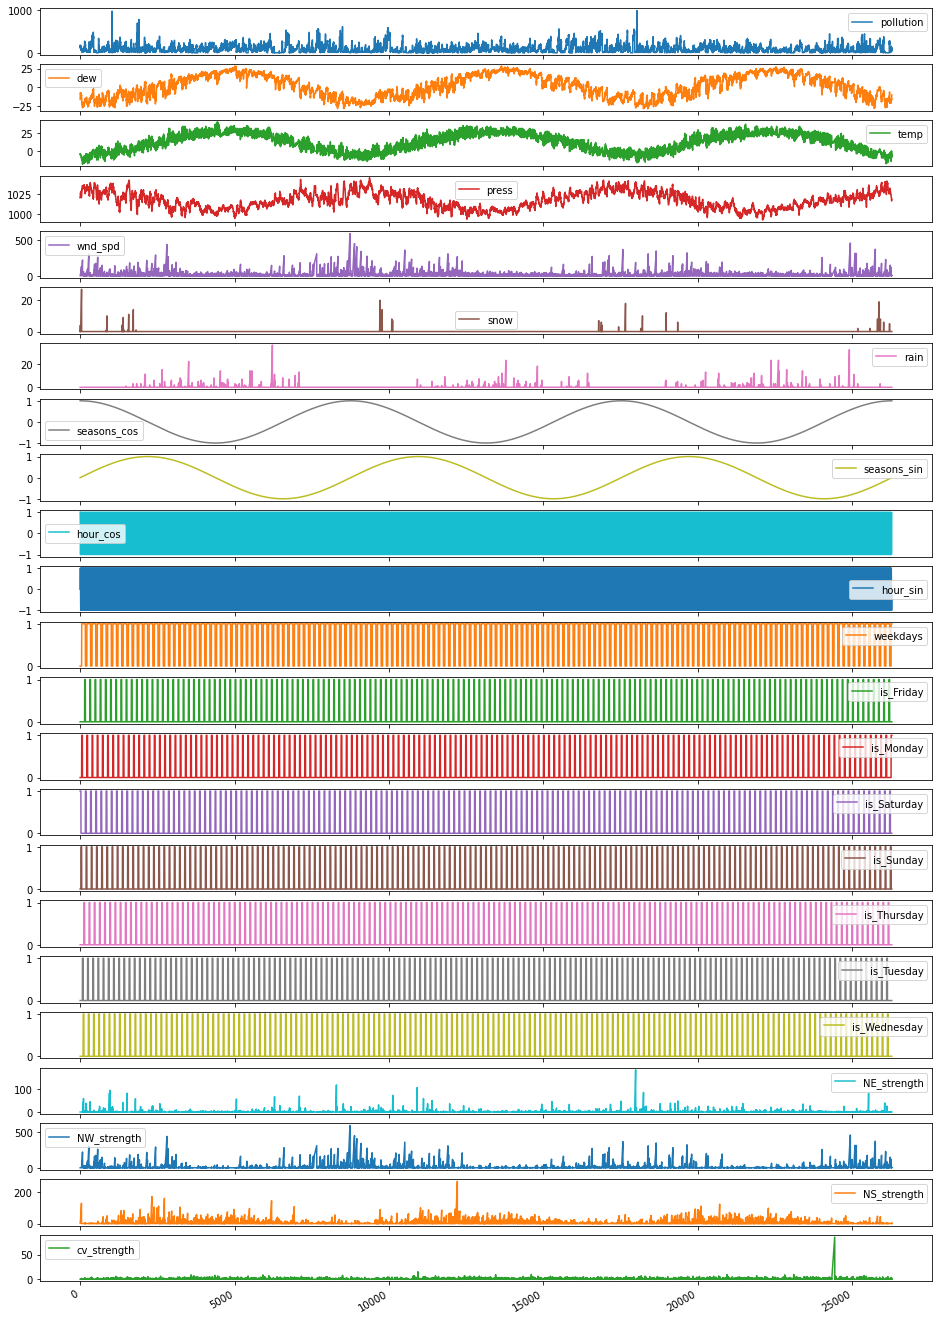

In [4]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/Assignments/GA3/preprocessed_data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

train_dataset.plot(subplots=True,figsize=(16,26))

## Extract train, validate and test features and labels

In the code below, we will split of a validation set that is the same size as the test set (1 year) at the end of the training set.

In [5]:
print(train_dataset.columns)
print(len(train_dataset.columns))

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'seasons_cos', 'seasons_sin', 'hour_cos', 'hour_sin', 'weekdays',
       'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Tuesday', 'is_Wednesday', 'NE_strength', 'NW_strength',
       'NS_strength', 'cv_strength'],
      dtype='object')
23


In [6]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

#using indexing, you can select which features you want to use (adapt to your needs)
# features = [4,5,6,7,11,12,13,14,15,16]
features = list(range(23))

# index of the pollution data in the complete preprocessed feature set 
pollution = 0


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

# data for retraining before testing
train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

# test data
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


# check
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 23)
(26280,)
(8760, 23)
(8760,)
(35040, 23)
(35040,)
(8760, 23)
(8760,)


## Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models. Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.


In [7]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = StandardScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

## Transforming the data into the right format for model training

In this assignment, you will use models with two types of inputs: 
- a dense network that only uses the current input features for prediction
- window-based and sequential networks that use time windows for prediction

In the code below, we define a helper function for each case.

In [8]:
# dense network:
# here you only need to take into account that we are predicting 3 steps ahead
# this means that the features of the first timestep (index 0)
# are used to predict the 4th pollution value (index 3) so the first 3 and the last 3 feature-samples labels are omitted

def create_dataset_dense(train, test, ahead=3):   # can use this with different 'ahead' values, but default is set to 3
    return train[:-ahead,:], test[ahead:]

X_train_d,r_train_d = create_dataset_dense(train_scaled,train_labels)
X_val_d,r_val_d = create_dataset_dense(val_scaled,val_labels)

X_train_all_d,r_train_all_d = create_dataset_dense(train_all_scaled,train_all_labels)
X_test_d,r_test_d = create_dataset_dense(test_scaled,test_labels)


print(X_train_d.shape)
print(r_train_d.shape)

(26277, 23)
(26277,)


In [9]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

# set chosen window size
WINDOW=5
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=WINDOW)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=WINDOW)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=WINDOW)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=WINDOW)

print(X_train_w.shape)
print(r_train_w.shape)



(26273, 5, 23)
(26273,)


## Simplest sandbox model

The simplest sandbox model you can make just uses the current pollution to predict the pollution of 6 hours ahead. In the code below, we create these predictions, and evaluate them, using a 'Plotresults' function.

In [10]:
# We use current pollution as prediction for the "dense" labels


from sklearn.metrics import mean_absolute_error
y_train_current = train_values[:-3,0]
y_val_current = val_values[:-3,0]
y_test_current = test_values[:-3,0]

mae_train_current = mean_absolute_error(r_train_d,y_train_current)
mae_val_current = mean_absolute_error(r_val_d,y_val_current)
mae_test_current = mean_absolute_error(r_test_d,y_test_current)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_current,
      "\n validation mae = ",mae_val_current,
      "\n test mae = ",mae_test_current)


"Current pollution" baseline:
 train mae =  26.28013 
 validation mae =  28.706179 
 test mae =  26.04659


The results show a pretty close match between train, validate and test scores. This can be expected, since this model involved no training. However, the small discrepancy between the validation set and the other two sets suggests that the validation year may contain some slightly more difficult samples (so not quite i.i.d.). Keep thin in mind when interpreting the performance of your models.

Finally, below, we give examples of how you can visualise the results for regression models. Feel free to come up with more interesting analyses if you can.

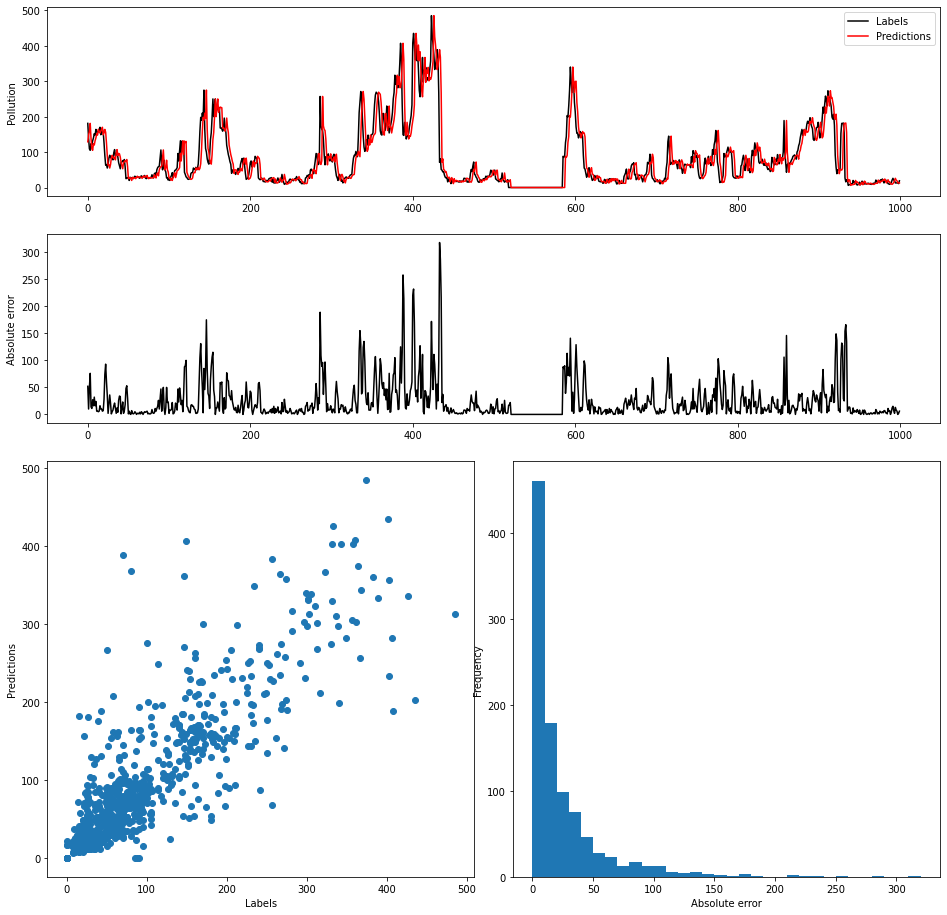

In [11]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualise first 1000 predictions
PlotResults(r_train_d[:1000],y_train_current[:1000])

## Building models

The code below offers a quick and dirty overview of how to construct and train models of different types.

When working in your assignment, make a new notebook for each type of model (and remove code that is not relevant for that model)!

The next models you need to tune are window-based models: the pollution-only baseline (dense, but you are free to try conv as well) and the 1Dconv model with multiple features. The code below demonstrates how to set up conv models. For dense models, you use the same windowed dataset creation. 

In [ ]:
WINDOW_SIZE = 24

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features

# note that in the current feature set, pollution is the first feature (index=0)

train_features = [0,] 

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=WINDOW_SIZE)


def my_Dense(num_features,learning_rate=0.001,hidden=[],ridge_param = 0.0,dropouts=[0.0]):
    # create linear modelmodel

    model = Sequential()
    model.add(Dropout(dropouts[0], input_shape=(num_features,)))
    for idx in range(len(hidden)):
      model.add(Dense(hidden[idx],activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
      model.add(Dropout(dropouts[idx+1]))
    model.add(Dense(1,activation='linear',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
    
    optim = tf.keras.optimizers.Adam(lr=learning_rate)

    # Compile model
    # Note that Tensorflow allows you to directly optimise MAE during training!
    
    model.compile(loss='mae', optimizer=optim, metrics=['mae','mse']) # keep extra metrics: here mse and mae without regularisation terms
    return model    


DenseWindowedModel = my_Dense(WINDOW_SIZE, learning_rate=0.01, hidden=[32, 16], dropouts=[0, 0.2, 0.2], ridge_param=1e-3)

DenseWindowedModel.summary()

batch_size = 64
epochs = 50

DW_history = DenseWindowedModel.fit(X_train_w, r_train_w,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
____________________________________________________

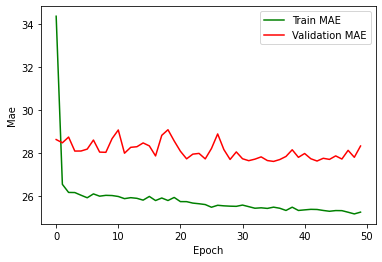

In [ ]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

plot_history(DW_history)

"Dense Windowed" baseline:
 train mae =  25.73243 
 validation mae =  28.339039
(26254, 1)
(8734, 1)


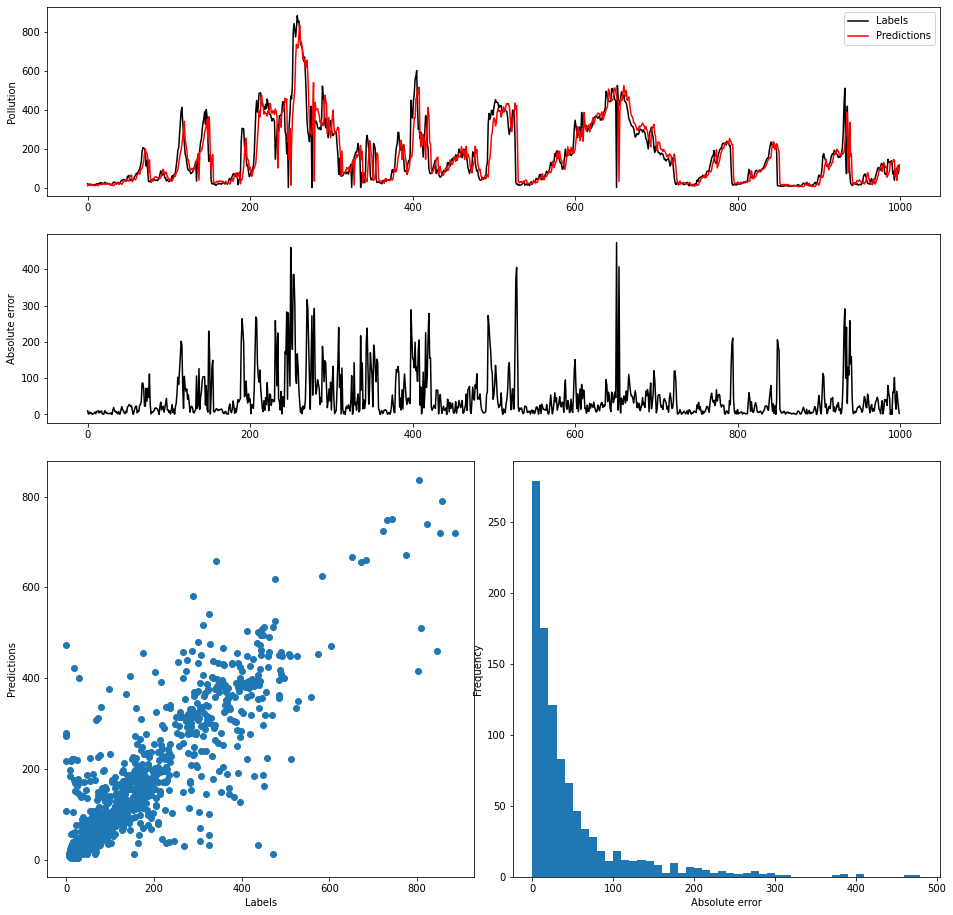

In [ ]:
y_train_DWmodel = DenseWindowedModel.predict(X_train_w)
y_val_DWmodel = DenseWindowedModel.predict(X_val_w)

mae_train_DWmodel = mean_absolute_error(r_train_w,y_train_DWmodel)
mae_val_DWmodel = mean_absolute_error(r_val_w,y_val_DWmodel)

print("\"Dense Windowed\" baseline:\n train mae = ",mae_train_DWmodel,
      "\n validation mae = ",mae_val_DWmodel)

print(y_train_DWmodel.shape)
print(y_val_DWmodel.shape)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_DWmodel[:1000,0])